# Implementing a GPT model from scratch
## Coding a LLM architecture

In [28]:
GPT_CONFIG_124M = {
    'vocab_size': 50257, # vocab size
    'context_length': 1024, # context length
    'emb_dim': 768, # embedding dimension
    'n_layers': 12, # number of transformer blocks
    'n_heads': 12, # number of attention heads
    'drop_rate': 0.1, # dropout rate
    'qkv_bias': False, # whether to use bias in the query, key, and value weights
}

In [29]:
import torch
import torch.nn as nn
from urllib3.poolmanager import key_fn_by_scheme

In [30]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        # placeholder for the transformer block
        self.trf_block = nn.Sequential(
            *[DummyTranformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        # use a placeholder for layer norm
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )

    def forward(self, x):
        batch_size, seq_len = x.shape
        tok_embeds = self.tok_emb(x)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTranformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # a simple place holder

    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # a simple place holder

    def forward(self, x):
        return x

In [31]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []
txt1 = 'Every effort moves your'
txt2 = 'Every day holds a'

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  534],
        [6109, 1110, 6622,  257]])


In [32]:
torch.manual_seed(123)

model = DummyGPTModel(cfg=GPT_CONFIG_124M)
logits = model(batch)
print(f"Output shape: {logits.shape}")
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [-0.2218,  0.2200, -0.5722,  ...,  3.4660,  0.7727,  0.5104]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


# 4.2 Normalizing activations with layer normalization

Layer normalization is a techique that normalizes the activities of a neuron across a batch of inputs.

the layer will have mean 0 and variance 1.


In [33]:
torch.manual_seed(123)

batch_example = torch.rand(2, 5)
print(batch_example)

tensor([[0.2961, 0.5166, 0.2517, 0.6886, 0.0740],
        [0.8665, 0.1366, 0.1025, 0.1841, 0.7264]])


In [34]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [35]:
mean = out.mean(dim=-1, keepdim=True)
print(mean)

tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)


In [36]:
var = out.var(dim=-1, keepdim=True)
print(var)

tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [37]:
torch.set_printoptions(sci_mode=False)

In [38]:
normed = (out - mean) / torch.sqrt(var)
print(normed.mean(dim=-1, keepdim=True))
# print(normed.var(dim=-1, keepdim=True))


tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)


In [39]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)  # unbiased true is population stats and False is sample stats
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift





In [40]:
3 * 5 + 5

20

In [41]:
ln = LayerNorm(6)
outputs_normed = ln(out)
print(outputs_normed)

tensor([[-0.9423, -0.9423,  0.6428,  1.6100,  0.5742, -0.9423],
        [-0.8160, -0.8160, -0.0111,  0.5306,  1.9286, -0.8160]],
       grad_fn=<AddBackward0>)


In [42]:
# print(outputs_normed.mean(dim=-1, keepdim=True))
print(outputs_normed.var(dim=-1, keepdim=True))

tensor([[1.1998],
        [1.1998]], grad_fn=<VarBackward0>)


# 4.3 Implementing a feed forward GELU activations

In [43]:
# implementing the approx GELU function from the original paper
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


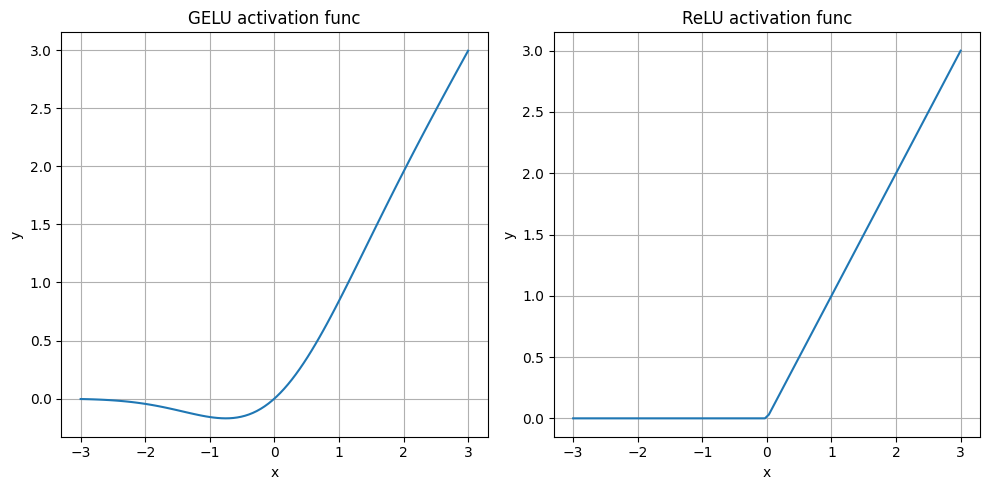

In [44]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(10, 5))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x.tolist(), y.tolist())
    plt.title(f"{label} activation func")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [45]:
768 * 4

3072

In [46]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']),
        )

    def forward(self, x):
        return self.layers(x)




In [47]:
ffn = FeedForward(cfg=GPT_CONFIG_124M)

In [48]:
x = torch.rand(2, 3, 768)
ffn(x).shape

torch.Size([2, 3, 768])

In [49]:
print(ffn.layers[0].weight.shape)
ffn.layers[0].weight

torch.Size([3072, 768])


Parameter containing:
tensor([[-0.0056,  0.0057,  0.0322,  ..., -0.0233, -0.0345,  0.0267],
        [ 0.0271, -0.0092,  0.0159,  ..., -0.0334, -0.0333,  0.0007],
        [ 0.0050,  0.0068, -0.0133,  ..., -0.0010,  0.0292,  0.0062],
        ...,
        [-0.0099, -0.0041,  0.0157,  ...,  0.0281,  0.0110, -0.0300],
        [-0.0180, -0.0102, -0.0077,  ..., -0.0289, -0.0045,  0.0041],
        [ 0.0310,  0.0098,  0.0148,  ..., -0.0227,  0.0137,  0.0336]],
       requires_grad=True)

# 4.4 Adding shortcut connections

In [55]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_size, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_size[0], layer_size[1]), GELU()),
            nn.Sequential(nn.Linear(layer_size[1], layer_size[2]), GELU()),
            nn.Sequential(nn.Linear(layer_size[2], layer_size[3]), GELU()),
            nn.Sequential(nn.Linear(layer_size[3], layer_size[4]), GELU()),
            nn.Sequential(nn.Linear(layer_size[4], layer_size[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            # compute the output of the current layer
            layer_output = layer(x)
            # check if a shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output

        return x


def print_gradients(model, x):
    # forward pass
    ouput = model(x)
    target = torch.tensor([[0.]])  # this is a placeholder for the target

    # calculate loss based on how close the target is to the output
    loss = torch.nn.MSELoss()(ouput, target)

    # backward pass to calculate the gradient
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(
                f"{name} has gradient mean of {param.grad.mean().item():.8f} and variance of {param.grad.var().item():.8f}")

In [56]:
layer_sizes = [3, 3, 3, 3, 3, 1]  # last has one output unit base on the target placeholder


In [57]:
sample_input = torch.tensor([[1., 2., 3.]])


In [58]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_size=layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00033439 and variance of 0.00000027
layers.1.0.weight has gradient mean of 0.00000608 and variance of 0.00000002
layers.2.0.weight has gradient mean of -0.00061409 and variance of 0.00000109
layers.3.0.weight has gradient mean of 0.00119859 and variance of 0.00000083
layers.4.0.weight has gradient mean of 0.00056759 and variance of 0.00004014


In [59]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_size=layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 1.05921996 and variance of 4.70400095
layers.1.0.weight has gradient mean of 2.14351177 and variance of 7.01437044
layers.2.0.weight has gradient mean of 0.96821487 and variance of 4.61460352
layers.3.0.weight has gradient mean of 1.26281226 and variance of 8.86768818
layers.4.0.weight has gradient mean of 20.08812714 and variance of 479.06140137


# 4.5 Connecting the attention and linear layers in a transformer block

In [60]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [61]:
from gpt_helpers import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias'],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x) # Shape (batch_size, num_tokens, emb_dim)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [62]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)

block = TransformerBlock(cfg=GPT_CONFIG_124M)
output = block(x)

In [64]:
x.shape

torch.Size([2, 4, 768])

In [65]:
output.shape

torch.Size([2, 4, 768])

# Coding the GPT model

In [67]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []
txt1 = 'Every effort moves your'
txt2 = 'Every day holds a'

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  534],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)

model = GPTModel(cfg=GPT_CONFIG_124M)
out = model(batch)

torch.Size([2, 4])

torch.Size([2, 4, 50257])

In [71]:
batch.numel()

8

In [74]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [76]:
# The original GPT2 model has some weights sharing,
# todo: this does not share weights between the token embedding and the output head. using shared weights will reduce the number of parameters.
# note shared weights are not sometimes helpful. it is a arbitary descicion choice
print(model.tok_emb.weight.shape)
print(model.out_head.weight.shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [78]:
# if shared weights architecture is use we would see something like

total_params = sum(p.numel() for p in model.parameters() )
print(f"Total number of parameters: {total_params - model.tok_emb.weight.numel():,}")

Total number of parameters: 124,412,160


# Generating text